In [1]:
import mne
import numpy as np
import pandas as pd
import seaborn as sns
from mne_connectivity import spectral_connectivity_epochs

from shared.helper_functions import *
from resting_state.settings import *
from settings_general import low_qual_chans, freq_bands_eeg

Let's load some general needed information

In [2]:
epoch_folder = select_folder("Select the folder that holds epoch files (starting with 'epochs_w_cluster_annotations')")
plot_folder = select_or_create_folder("Create or select a folder the plots will be saved to")

To inspect only the Default Mode Network, we only can exclude the Somatosensory and Visual cortex as well as of course the EMGs if we want to.

In [4]:
emg_chans = ['EMG_L', 'EMG_R']
skull_chans = ['S1_L', 'S1_R', 'V1_R']

## Let's load all needed epochs

In [5]:
all_subject_epochs = []
for file in os.listdir(epoch_folder):
    subj_id = file.split('_')[-1].split('-')[0]
    if not file.startswith('epochs_w_cluster_annotations') or int(subj_id) in omitted_after_clustering or int(
            subj_id) in omitted_other:
        continue
    all_subject_epochs.append(mne.read_epochs(os.path.join(epoch_folder, file), preload=True))

Reading C:\Users\Olle de Jong\Documents\MSc Biology\rp2\rp2_data\resting_state\output\epochs\epochs_w_cluster_annotations_39489-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    4998.53 ms
        0 CTF compensation matrices available
Adding metadata with 6 columns
594 matching events found
No baseline correction applied
0 projection items activated
Reading C:\Users\Olle de Jong\Documents\MSc Biology\rp2\rp2_data\resting_state\output\epochs\epochs_w_cluster_annotations_39508-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    4998.53 ms
        0 CTF compensation matrices available
Adding metadata with 6 columns
389 matching events found
No baseline correction applied
0 projection items activated
Reading C:\Users\Olle de Jong\Documents\MSc Biology\rp2\rp2_data\resting_state\output\epochs\epochs_w_cluster_annotations_78211-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00

## Multivariate connectivity analysis

Compute the multivariate connectivity measures for all subject's epochs

#### First, we use all EEG channels

Now, we also include the skull electrodes, and of course still exclude the EMGs

In [11]:
results_df = pd.DataFrame()

# for each subject, get the resting/active/sleep epochs, drop the emg channels and calculate the mic and mim
for subj_epochs in all_subject_epochs:
    subject_id = int(subj_epochs.metadata['animal_id'].iloc[0])
    annotations = cluster_annotations[subject_id]
    genotype = subj_epochs.metadata['genotype'].iloc[0]
    subj_epochs = subj_epochs.load_data().drop_channels(emg_chans)
    
    for label, index in annotations.items():
        state_epochs = subj_epochs[subj_epochs.metadata["cluster"] == index]

        (mic, mim) = spectral_connectivity_epochs(state_epochs, method=['mic', 'mim'], n_jobs=-1, fmin=1.01, fmax=100, verbose='WARNING')
    
        results_df = pd.concat([results_df, pd.DataFrame({
            'animal_id' : subject_id,
            'genotype' : genotype,
            'state': label,
            'freqs' : mic.freqs,
            'mic' : mic.get_data()[0,:],
            'mim' : mim.get_data()[0,:],
            'low_qual_chans': True if subject_id in low_qual_chans.keys() else False
        })])

Split the data into the states

In [12]:
resting_results = results_df[results_df.state == 'rest']
sleep_results = results_df[results_df.state == 'sleep']
active_results = results_df[results_df.state == 'active']

Line-plot the multivariate connectivity measures to see what the data actually looks like

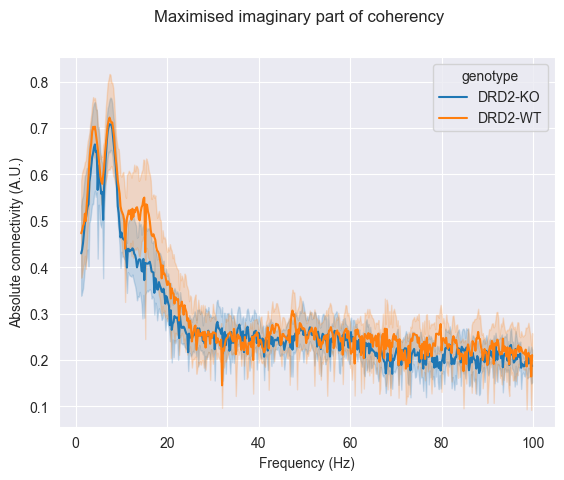

In [13]:
fig, ax = plt.subplots(1, 1)
sns.lineplot(x=resting_results.freqs, y=np.abs(resting_results.mic), hue=resting_results.genotype, errorbar=('ci', 95), ax=ax)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Absolute connectivity (A.U.)")
fig.suptitle("Maximised imaginary part of coherency")
plt.show()

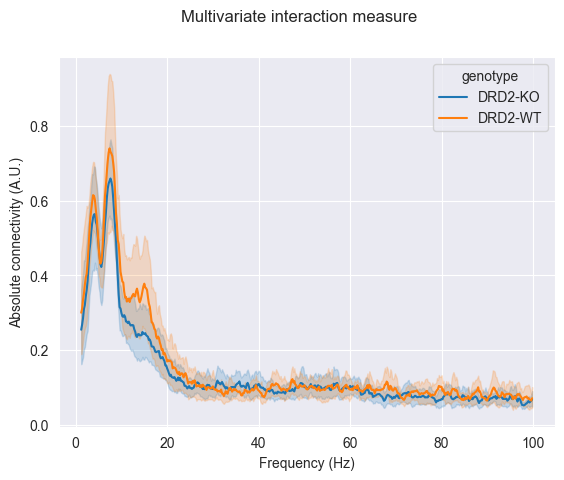

Normalised MIM has a maximum value of 0.12 for KOs
Normalised MIM has a maximum value of 0.14 for WTs


In [14]:
fig, ax = plt.subplots(1, 1)
sns.lineplot(resting_results, x='freqs', y='mim', hue='genotype', errorbar=('ci', 95), ax=ax)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Absolute connectivity (A.U.)")
fig.suptitle("Multivariate interaction measure")
plt.show()

n_channels = 8
normalised_mim_ko = resting_results[resting_results.genotype == 'DRD2-KO'].mim / n_channels
normalised_mim_wt = resting_results[resting_results.genotype == 'DRD2-WT'].mim / n_channels
print(f"Normalised MIM has a maximum value of {normalised_mim_ko.max():.2f} for KOs")
print(f"Normalised MIM has a maximum value of {normalised_mim_wt.max():.2f} for WTs")

Let's look at the difference between the genotypes in the different bands

In [18]:
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(12, 18))
axs = axs.ravel()

for i, (band, (start, end)) in enumerate(freq_bands_eeg.items()):
    slice_data = resting_results[(resting_results.freqs >= start) & (resting_results.freqs <= end)]
    sns.lineplot(x=slice_data.freqs, y=np.abs(slice_data.mic), hue=slice_data.genotype, errorbar=('ci', 95), ax=axs[i])
    if i == 0:
        axs[i].set_title('Maximised imaginary part of coherency (MIC) per frequency band, colored by genotype (all EEG channels)')

save_figure(os.path.join(plot_folder, f"resting_state/connectivity/multivariate/multivar_MIC_all_eeg_chans.pdf"))

In [19]:
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(12, 18))
axs = axs.ravel()

for i, (band, (start, end)) in enumerate(freq_bands_eeg.items()):
    slice_data = resting_results[(resting_results.freqs >= start) & (resting_results.freqs <= end)]
    sns.lineplot(slice_data, x='freqs', y='mim', hue='genotype', errorbar=('ci', 95), ax=axs[i])
    if i == 0:
        axs[i].set_title('Multivariate interaction measure (MIM) per frequency band, colored by genotype (all EEG channels)')

save_figure(os.path.join(plot_folder, f"resting_state/connectivity/multivariate/multivar_MIM_all_eeg_chans.pdf"))

#### Now we do the same, but using only the depth electrodes

In [9]:
results_df = pd.DataFrame()

# for each subject, get the resting/active/sleep epochs, drop the non-depth electrodes and calculate the mic and mim
for subj_epochs in all_subject_epochs:
    subject_id = subj_epochs.metadata['animal_id'].iloc[0]
    annotations = cluster_annotations[int(subject_id)]
    genotype = subj_epochs.metadata['genotype'].iloc[0]
    subj_epochs = subj_epochs.load_data().drop_channels(skull_chans)
    
    for label, index in annotations.items():
        state_epochs = subj_epochs[subj_epochs.metadata["cluster"] == index]

        (mic, mim) = spectral_connectivity_epochs(state_epochs, method=['mic', 'mim'], n_jobs=-1, fmin=1.01, fmax=100, verbose='WARNING')
    
        results_df = pd.concat([results_df, pd.DataFrame({
            'animal_id' : subject_id,
            'genotype' : genotype,
            'state': label,
            'freqs' : mic.freqs,
            'mic' : mic.get_data()[0,:],
            'mim' : mim.get_data()[0,:],
            'low_qual_chans': True if subject_id in low_qual_chans.keys() else False
        })])

Split the data into the states

In [10]:
resting_results = results_df[results_df.state == 'rest']
sleep_results = results_df[results_df.state == 'sleep']
active_results = results_df[results_df.state == 'active']

Line-plot the multivariate connectivity measures to see what the data actually looks like

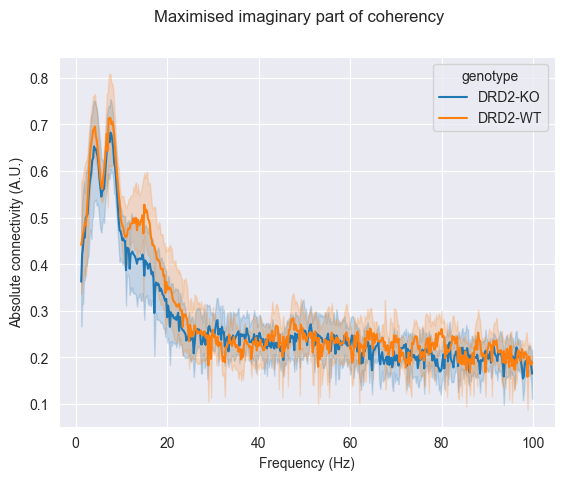

In [11]:
fig, ax = plt.subplots(1, 1)
sns.lineplot(x=resting_results.freqs, y=np.abs(resting_results.mic), hue=resting_results.genotype, errorbar=('ci', 95), ax=ax)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Absolute connectivity (A.U.)")
fig.suptitle("Maximised imaginary part of coherency")
plt.show()

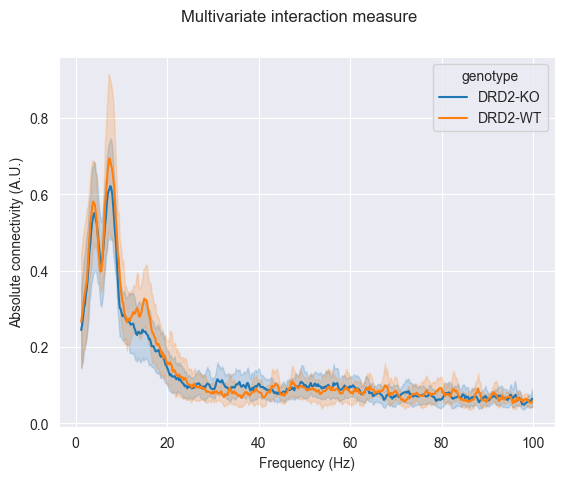

Normalised MIM has a maximum value of 0.12 for KOs
Normalised MIM has a maximum value of 0.14 for WTs


In [12]:
fig, ax = plt.subplots(1, 1)
sns.lineplot(resting_results, x='freqs', y='mim', hue='genotype', errorbar=('ci', 95), ax=ax)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Absolute connectivity (A.U.)")
fig.suptitle("Multivariate interaction measure")
plt.show()

n_channels = 8
normalised_mim_ko = resting_results[resting_results.genotype == 'DRD2-KO'].mim / n_channels
normalised_mim_wt = resting_results[resting_results.genotype == 'DRD2-WT'].mim / n_channels
print(f"Normalised MIM has a maximum value of {normalised_mim_ko.max():.2f} for KOs")
print(f"Normalised MIM has a maximum value of {normalised_mim_wt.max():.2f} for WTs")

Let's look at the difference between the genotypes in the different bands

In [13]:
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(12, 18))
axs = axs.ravel()

for i, (band, (start, end)) in enumerate(freq_bands_eeg.items()):
    slice_data = resting_results[(resting_results.freqs >= start) & (resting_results.freqs <= end)]
    sns.lineplot(x=slice_data.freqs, y=np.abs(slice_data.mic), hue=slice_data.genotype, errorbar=('ci', 95), ax=axs[i])
    if i == 0:
        axs[i].set_title('Maximised imaginary part of coherency (MIC) per frequency band, colored by genotype (depth EEG channels)')

save_figure(os.path.join(plot_folder, f"resting_state/connectivity/multivariate/multivar_MIC_depth_eeg_chans.pdf"))

In [14]:
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(12, 18))
axs = axs.ravel()

for i, (band, (start, end)) in enumerate(freq_bands_eeg.items()):
    slice_data = resting_results[(resting_results.freqs >= start) & (resting_results.freqs <= end)]
    sns.lineplot(slice_data, x='freqs', y='mim', hue='genotype', errorbar=('ci', 95), ax=axs[i])
    if i == 0:
        axs[i].set_title('Multivariate interaction measure (MIM) per frequency band, colored by genotype (depth EEG channels)')

save_figure(os.path.join(plot_folder, f"resting_state/connectivity/multivariate/multivar_MIM_depth_eeg_chans.pdf"))

It seems that, when you average the MIC and MIM per frequency within each frequency band, that there's a significant difference in mean.


#### Let's exclude the subjects that have low quality channels

In [15]:
len(resting_results)

7904

In [16]:
resting_results = resting_results[resting_results.low_qual_chans == False]

In [17]:
len(resting_results)

6422

In [18]:
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(12, 18))
axs = axs.ravel()

for i, (band, (start, end)) in enumerate(freq_bands_eeg.items()):
    slice_data = resting_results[(resting_results.freqs >= start) & (resting_results.freqs <= end)]
    sns.lineplot(x=slice_data.freqs, y=np.abs(slice_data.mic), hue=slice_data.genotype, errorbar=('ci', 95), ax=axs[i])
    if i == 0:
        axs[i].set_title('Maximised imaginary part of coherency (MIC) per frequency band, colored by genotype (depth EEG channels)')

save_figure(os.path.join(plot_folder, f"resting_state/connectivity/multivariate/multivar_MIC_depth_eeg_chans_wo_low_qual_chans.pdf"))

In [19]:
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(12, 18))
axs = axs.ravel()

for i, (band, (start, end)) in enumerate(freq_bands_eeg.items()):
    slice_data = resting_results[(resting_results.freqs >= start) & (resting_results.freqs <= end)]
    sns.lineplot(slice_data, x='freqs', y='mim', hue='genotype', errorbar=('ci', 95), ax=axs[i])
    if i == 0:
        axs[i].set_title('Multivariate interaction measure (MIM) per frequency band, colored by genotype (depth EEG channels)')

save_figure(os.path.join(plot_folder, f"resting_state/connectivity/multivariate/multivar_MIM_depth_eeg_chans_wo_low_qual_chans.pdf"))

We can now inspect the output PDFs on what the effect is of removing the 'low quality channels'. Also, we can compare the multivariate connectivity between all electrodes, as well as only the depth electrodes.